In [7]:
import pennylane as qml
from pennylane import numpy as np
import qiskit
from qiskit import *
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from pennylane.optimize import NesterovMomentumOptimizer
from sklearn.utils import shuffle
import random
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pdfrom 
from IPython.display import Image


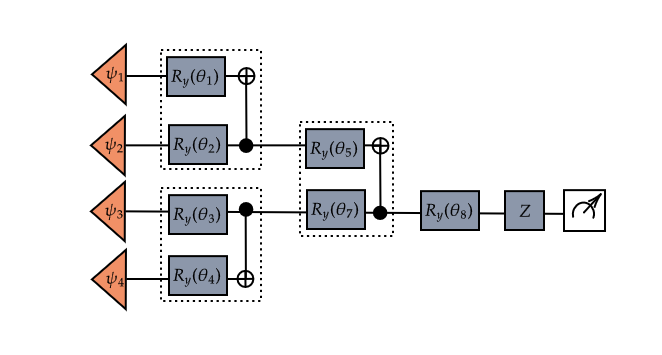

In [9]:
#the circuit diagram for the TTN
Image("ttn.png")

In [3]:
#initialise pennylane QNode with 4 qubits
dev = qml.device("default.qubit", wires=4,shots = 50)

In [4]:
#load data for training and validation
iris = datasets.load_iris()
idx = iris.target != 2
features = iris.data[idx].astype(np.float32)
labels = iris.target[idx].astype(np.float32)

In [5]:
#split data into training and validation sets
np.random.seed(0)
num_data = len(features)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
features_train = features[index[:num_train]]
labels_train = labels[index[:num_train]]
features_val = features[index[num_train:]]
labels_val = labels[index[num_train:]]

In [6]:

#fuction for encoding features into the amplitudes of the 4 qubits,
#the features(b[i]) are scaled to lie between (0,pi/2) and encoded 
#as cos(b[i])|0 > + sin(b[i])|1 >
def statepreparation(b):
    for i in range(4):
        qml.RY(np.cos(np.pi*b[i]/max(b)), wires=i)

    

In [7]:
#paramatrised TTN circuit with 3 layers,returns <Z> of 3rd Qubit. This is used as the label
#for the classifiaction
@qml.qnode(dev)
def circuit(params,a = None):
    statepreparation(a)
    qml.RY(params[0],wires = 0)
    qml.RY(params[1],wires = 1)
    qml.RY(params[2],wires = 2)
    qml.RY(params[3],wires = 3)
    qml.CNOT(wires = [1,0])
    qml.CNOT(wires = [3,2])
    qml.RY(params[4],wires = 1)
    qml.RY(params[5],wires = 2)
    qml.CNOT(wires = [1,2])
    qml.RY(params[6],wires = 2)
    return qml.expval(qml.PauliZ(2))

In [8]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [9]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [10]:
def cost(params,features,labels):
    predictions = [circuit(params, a=f) for f in features]
    return square_loss(labels, predictions)
   

In [16]:
# initialise the optimizer
opt = NesterovMomentumOptimizer(0.01)

#batch_sie for stochastic Gradient Descent
batch_size = 5

# set the number of steps
steps = 60
# set the initial parameter values
init_params = np.random.rand(7)
params = init_params
cost_list = np.zeros(steps)
acc_train_list = np.zeros(steps)
acc_val_list = np.zeros(steps)

for it in range(steps):
    
     # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    features_train_batch = features_train[batch_index]
    labels_train_batch = labels_train[batch_index]
    params = opt.step(lambda v: cost(v, features_train_batch, labels_train_batch), params)

    # Compute predictions on train and validation set
    
    
    predictions_train = np.array([(circuit(params, a=f)) for f in features_train])

    #thresholding the predicted labels
    predictions_train[predictions_train > 0.5] = 1
    predictions_train[predictions_train < 0.5] = 0
    predictions_val = np.array([(circuit(params, a=f)) for f in features_val])
    predictions_val[predictions_val > 0.5] = 1
    predictions_val[predictions_val < 0.5] = 0
    
    
    # Compute accuracy on train and validation set
    acc_train_list[it] = accuracy(labels_train, predictions_train)
    acc_val_list[it] = accuracy(labels_val, predictions_val)
    
    cost_list[it] = cost(params, features, labels)
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1,cost_list[it] , acc_train_list[it], acc_val_list[it])
    )

print("Optimized rotation angles: {}".format(params))




Iter:     1 | Cost: 0.3377316 | Acc train: 0.5200000 | Acc validation: 0.4800000 
Iter:     2 | Cost: 0.3235450 | Acc train: 0.5333333 | Acc validation: 0.4800000 
Iter:     3 | Cost: 0.3050162 | Acc train: 0.5333333 | Acc validation: 0.4800000 
Iter:     4 | Cost: 0.2844399 | Acc train: 0.5333333 | Acc validation: 0.4800000 
Iter:     5 | Cost: 0.2603515 | Acc train: 0.5466667 | Acc validation: 0.5200000 
Iter:     6 | Cost: 0.2355350 | Acc train: 0.5600000 | Acc validation: 0.5200000 
Iter:     7 | Cost: 0.2116550 | Acc train: 0.5733333 | Acc validation: 0.5200000 
Iter:     8 | Cost: 0.1895039 | Acc train: 0.6000000 | Acc validation: 0.5200000 
Iter:     9 | Cost: 0.1694259 | Acc train: 0.6266667 | Acc validation: 0.5600000 
Iter:    10 | Cost: 0.1505679 | Acc train: 0.6933333 | Acc validation: 0.6800000 
Iter:    11 | Cost: 0.1337834 | Acc train: 0.7333333 | Acc validation: 0.7200000 
Iter:    12 | Cost: 0.1190910 | Acc train: 0.8000000 | Acc validation: 0.7600000 
Iter:    13 | Co

Text(0, 0.5, 'accuracy')

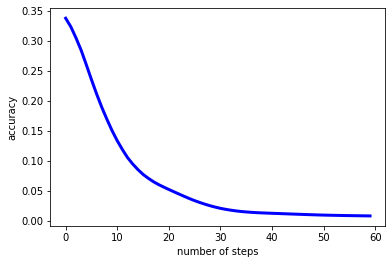

In [42]:
#plot of cost function vs time steps
plt.plot(range(steps),cost_list,color ='b',linewidth=3)
plt.xlabel('number of steps')
plt.xlabel('number of steps')
plt.ylabel('accuracy')

Text(0, 0.5, 'accuracy')

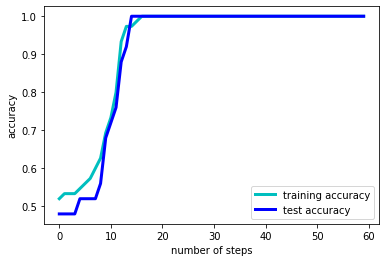

In [31]:
# plot of accuracy vs time steps
df=pd.DataFrame({'number of steps': range(steps),  
                 'training accuracy': acc_train_list,
                 'test accuracy': acc_val_list })

plt.plot( 'number of steps', 'training accuracy', data=df,color ='c',linewidth=3)
plt.plot('number of steps','test accuracy', data = df,color ='b',linewidth=3)
plt.legend()
plt.xlabel('number of steps')
plt.ylabel('accuracy')

References:

https://arxiv.org/abs/1804.03680